# TP3 — Clustering & Word Embeddings    SECONDE SESSION
# Etudiant : Lamblin Ngueyap



## Q1 — Choix de la décennie & détection des données
Paramètre de décennie et détection automatique du dossier contenant les `.txt` de la période (ex. 1890–1899).

In [1]:


import os, re
from pathlib import Path

DECADE = "1890"
DECADE_PREFIX = DECADE[:-1]  # '189' pour 1890–1899
year_pattern = re.compile(rf"(?<!\d){DECADE_PREFIX}\d(?!\d)")

def find_data_dir():
    candidates = [
        Path('../data/txt'), Path('./data/txt'), Path('data/txt'),
        Path('../txt'), Path('./txt'), Path('txt'),
        Path('../data/corpus'), Path('./data/corpus'), Path('data/corpus')
    ]
    for p in candidates:
        if p.exists() and p.is_dir():
            decade_files = [x for x in p.iterdir()
                            if x.suffix.lower()=='.txt' and year_pattern.search(x.name)]
            if decade_files:
                return p
    # Fallback: scan limité
    from collections import Counter
    parents = []
    for root in [Path('.'), Path('..')]:
        for x in root.rglob('*.txt'):
            if year_pattern.search(x.name):
                parents.append(x.parent)
    if parents:
        return Counter(parents).most_common(1)[0][0]
    return None

data_dir = find_data_dir()
if data_dir is None:
    raise FileNotFoundError("Dossier des textes introuvable. Renseigne `data_dir = Path('/chemin/vers/txt')`.")
print("Dossier détecté:", data_dir)

files_paths = sorted([p for p in data_dir.iterdir()
                      if p.suffix.lower()=='.txt' and year_pattern.search(p.name)])
assert files_paths, "Aucun .txt 1890–1899 détecté."
files = [p.name for p in files_paths]
texts = [p.read_text(encoding='utf-8') for p in files_paths]

print(f"Documents chargés : {len(files)} fichiers — exemple:", files[:5])


Dossier détecté: tac/data/txt
Documents chargés : 900 fichiers — exemple: ['KB_JB838_1890-01-05_01-00004.txt', 'KB_JB838_1890-01-06_01-00003.txt', 'KB_JB838_1890-01-08_01-00003.txt', 'KB_JB838_1890-01-09_01-00003.txt', 'KB_JB838_1890-01-12_01-00004.txt']


## Q2 — Clustering des documents (TF‑IDF + K‑means)
Vectorisation TF‑IDF en français, sélection de **k** (silhouette/CH/inertie), apprentissage final, **top termes** et échantillons de fichiers par cluster.

In [2]:

# Vectorisation TF-IDF
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

french_stop = stopwords.words('french')

vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=french_stop,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.6,
    norm='l2'
)

tfidf = vectorizer.fit_transform(texts)
tfidf


/Users/elfabnyl/Documents/STIC/tac_venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes', 'meme'] not in stop_words.
  warnings.warn(


<900x321843 sparse matrix of type '<class 'numpy.float64'>'
	with 2523343 stored elements in Compressed Sparse Row format>

In [3]:

# Sélection de k
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_k(X, ks=range(4, 13), random_state=42):
    rows=[]
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels, metric='euclidean')
        try:
            ch = calinski_harabasz_score(X, labels)
        except Exception:
            ch = calinski_harabasz_score(X.toarray(), labels)
        rows.append((k, sil, ch, km.inertia_))
    return pd.DataFrame(rows, columns=['k','silhouette','calinski_harabasz','inertia'])

k_eval = evaluate_k(tfidf)
display(k_eval.sort_values('silhouette', ascending=False).head())
best_k = int(k_eval.sort_values(['silhouette','calinski_harabasz'], ascending=False).iloc[0]['k'])
print("k retenu (max silhouette → tie-break CH):", best_k)


,k,silhouette,calinski_harabasz,inertia
0,4,0.051022,30.140916,767.905846
3,7,0.042841,17.500495,756.454250
1,5,0.038391,24.108686,763.171150
7,11,0.015208,11.409205,749.245282
2,6,0.011240,20.270477,759.318011


k retenu (max silhouette → tie-break CH): 4


In [4]:

# K-means final + top termes + exemples
from collections import defaultdict
import numpy as np

km = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(tfidf)
labels = km.labels_

terms = vectorizer.get_feature_names_out()
order = km.cluster_centers_.argsort()[:, ::-1]
topn = 12
top_terms = {i: [terms[j] for j in order[i, :topn]] for i in range(best_k)}

print("Top termes par cluster (12):")
for cl, t in top_terms.items():
    print(f"\nCluster {cl}:\n" + ", ".join(t))

cluster_docs = defaultdict(list)
for i, lab in enumerate(labels):
    cluster_docs[lab].append(files[i])
print("\nExemples de fichiers par cluster (jusqu'à 5):")
for cl in sorted(cluster_docs):
    print(f"\nCluster {cl}:")
    for d in cluster_docs[cl][:5]:
        print(" -", d)


Top termes par cluster (12):

Cluster 0:
dem, pl, ag, tout faire, ad, louer, ec, cuis, sach, rossel, ag rossel, dem pl

Cluster 1:
quo, uno, gouvernement, ligne, etaient, ot, question, faits, quelque, ministre, yeux, roi

Cluster 2:
louer, actions, ag, vendre, id, ad, ch, ec, av, dem, rossel, pr

Cluster 3:
notaire, contenant, notaires, ares, louee, centiares, encheres, etude, rentier, portee, paumer, maison rentier

Exemples de fichiers par cluster (jusqu'à 5):

Cluster 0:
 - KB_JB838_1890-01-29_01-00004.txt
 - KB_JB838_1890-02-05_01-00008.txt
 - KB_JB838_1890-02-16_01-00004.txt
 - KB_JB838_1890-04-01_01-00004.txt
 - KB_JB838_1890-05-11_01-00003.txt

Cluster 1:
 - KB_JB838_1890-01-15_01-00001.txt
 - KB_JB838_1890-01-16_01-00002.txt
 - KB_JB838_1890-01-20_01-00001.txt
 - KB_JB838_1890-01-25_01-00001.txt
 - KB_JB838_1890-01-27_01-00002.txt

Cluster 2:
 - KB_JB838_1890-01-08_01-00003.txt
 - KB_JB838_1890-01-09_01-00003.txt
 - KB_JB838_1890-01-24_01-00003.txt
 - KB_JB838_1890-03-09_01-000

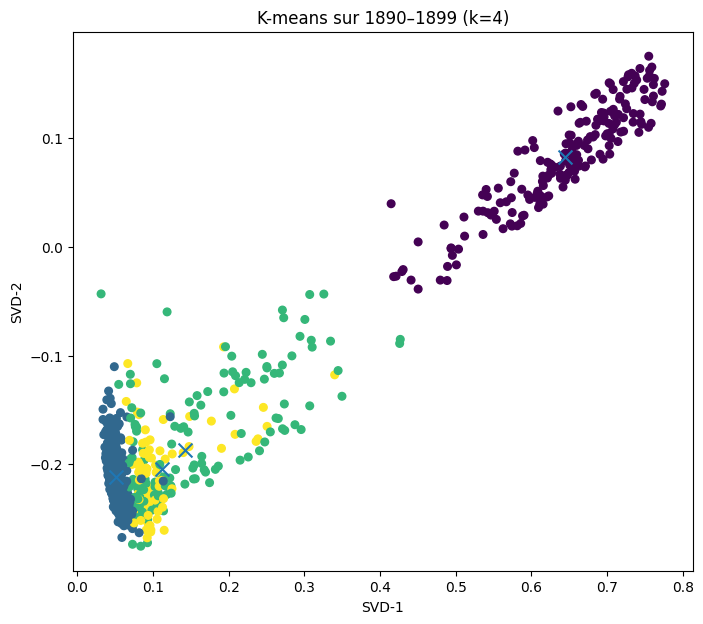

In [5]:

# Visualisation 2D (SVD sur TF-IDF creux)
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=2, random_state=42)
reduced = svd.fit_transform(tfidf)

plt.figure(figsize=(8, 7))
plt.scatter(reduced[:,0], reduced[:,1], c=labels, s=30)
centroids_2d = km.cluster_centers_.dot(svd.components_.T)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker="x", s=100)
plt.title(f"K-means sur {DECADE_PREFIX}0–{DECADE_PREFIX}9 (k={best_k})")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2")
plt.show()


## Q3 — Interprétation des clusters (à compléter après exécution)
- Pour chaque cluster, commente **thème/auteurs/genre** à partir des *top termes* et des exemples de fichiers.
- Indique si certains clusters sont trop généraux/spécifiques et ce que changerait un autre `k`.

> **Notes rapides** (à remplir) :
- Cluster 0 → …
- Cluster 1 → …
- …

## Q4 — Préparation des données `sents.txt`


In [13]:

from pathlib import Path

def find_sents_file():
    
    candidates = [
        Path('data/sents.txt'),
        Path('./data/sents.txt'),
        Path('../data/sents.txt')
    ]
    for p in candidates:
        if p.is_file():
            return p

    
    for root in (Path('.'), Path('..')):
        for x in root.rglob('sents.txt'):
            if x.is_file() and x.name == 'sents.txt':
                return x

    return None

sents_path = find_sents_file()
if sents_path is None:
    raise FileNotFoundError(
        "`sents.txt` introuvable. Place-le dans `data/` (ex: data/sents.txt) "
        "ou renseigne manuellement : sents_path = Path('/chemin/vers/sents.txt')"
    )
print("sents.txt:", sents_path)


sents.txt: tac/data/sents.txt


## Q5 — Entraînement Word2Vec (variations de `window` et `min_count`)
Entraîne plusieurs modèles Word2Vec sur `sents.txt` en faisant varier `window` et `min_count`. Les autres hyperparamètres sont fixés pour la reproductibilité.

In [9]:
import re, unicodedata, random
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

random_seed = 42

def normalize_text(s):
    s = unicodedata.normalize('NFKD', s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s

class ReiterSentences:
    """Itérable ré-entrant: chaque appel à __iter__ rouvre le fichier.
       Compatible avec epochs > 1 pour Gensim."""
    def __init__(self, path):
        self.path = str(path)
    def __iter__(self):
        with open(self.path, "r", encoding="utf-8") as f:
            for line in f:
                line = normalize_text(line.strip().lower())
                if not line:
                    continue
                
                yield simple_preprocess(line)

corpus = ReiterSentences(sents_path)

# Grille d'hyperparamètres à tester (exigences du TP: varier window & min_count)
grids = {"window": [2, 5, 8], "min_count": [2, 5]}
# Hyperparamètres fixes pour reproductibilité (workers=1 pour résultats stables)
fixed = dict(vector_size=100, sg=1, negative=10, workers=1, seed=random_seed, epochs=5)

models = {}
for w in grids["window"]:
    for mc in grids["min_count"]:
        tag = f"w{w}_mc{mc}"
        print("Training", tag)
        model = Word2Vec(sentences=corpus, window=w, min_count=mc, **fixed)
        models[tag] = model

print("Nombre de modèles entraînés:", len(models))

Training w2_mc2
Training w2_mc5
Training w5_mc2
Training w5_mc5
Training w8_mc2
Training w8_mc5
Nombre de modèles entraînés: 6


## Q6 — Comparaison et choix du meilleur modèle
On compare les modèles selon des **heuristiques** simples : taille du vocabulaire, couverture sur des mots fréquents et moyenne des similarités des *top‑N* voisins pour des ancres. Le meilleur est choisi en priorité par la **stabilité des voisins** puis par la **couverture**.

In [10]:

from collections import Counter
import numpy as np

# Sélection d'ancres : top mots fréquents (hors stopwords basiques)
basic_stop = set("le la les de des du un une et en que qui dans au aux pour par sur plus ne pas".split())

def top_anchor_words(path, k=12):
    cnt = Counter()
    for toks in iter_sentences(path):
        cnt.update(t for t in toks if t not in basic_stop)
    anchors = [w for w,_ in cnt.most_common(60) if len(w)>=3][:k]
    return anchors

anchors = top_anchor_words(sents_path, k=12)
print("Ancres:", anchors)

def model_summary(tag, model, anchors, topn=10):
    vocab_size = len(model.wv)
    coverage = sum(1 for a in anchors if a in model.wv) / len(anchors)
    sims = []
    neighbors = {}
    for a in anchors:
        if a in model.wv:
            top = model.wv.most_similar(a, topn=topn)
            neighbors[a] = top
            if top:
                sims.append(np.mean([s for _,s in top]))
    stability = float(np.mean(sims)) if sims else 0.0
    return dict(tag=tag, vocab=vocab_size, coverage=coverage, stability=stability, neighbors=neighbors)

summaries = [model_summary(tag, m, anchors) for tag, m in models.items()]
ranked = sorted(summaries, key=lambda d:(d["stability"], d["coverage"], d["vocab"]), reverse=True)
best = ranked[0]
print("Classement (top 3):")
for r in ranked[:3]:
    print(r["tag"], "→", f"stability={r['stability']:.3f}, coverage={r['coverage']:.2f}, vocab={r['vocab']}")
best_tag = best["tag"]
print("\n➡️ Modèle retenu:", best_tag)


Ancres: ['rue', 'est', 'dem', 'avec', 'tout', 'mais', 'son', 'elle', 'faire', 'vous', 'bruxelles', 'nous']
Classement (top 3):
w5_mc2 → stability=0.797, coverage=1.00, vocab=163129
w8_mc2 → stability=0.797, coverage=1.00, vocab=163129
w2_mc2 → stability=0.785, coverage=1.00, vocab=163129

➡️ Modèle retenu: w5_mc2


## Q7 — Explorations `similarity` et `most_similar`
Exemples d’analyses sur le **modèle retenu**. Modifie `queries_most_similar` et `pairs_similarity` selon tes besoins.

In [11]:

model = models[best_tag]
queries_most_similar = anchors[:6]  
pairs_similarity = [
    ("amour","haine"),
    ("roi","reine"),
    ("france","paris")
]

print("Most similar (quelques requêtes):")
for q in queries_most_similar:
    if q in model.wv:
        print(f"\n[{q}]")
        for w,s in model.wv.most_similar(q, topn=10):
            print(f" - {w:>15} : {s:.3f}")
    else:
        print(f"\n[{q}] — hors vocabulaire")

print("\nSimilarity (quelques paires):")
for a,b in pairs_similarity:
    if a in model.wv and b in model.wv:
        sim = model.wv.similarity(a,b)
        print(f"({a}, {b}) = {sim:.3f}")
    else:
        print(f"({a}, {b}) — hors vocabulaire")


Most similar (quelques requêtes):

[rue]
 -             ruo : 0.976
 -             rne : 0.921
 -             rua : 0.920
 -            riie : 0.903
 -             rae : 0.895
 -             ruc : 0.892
 -            rite : 0.873
 -            rtie : 0.863
 -              ru : 0.862
 -             nie : 0.853

[est]
 -             ost : 0.880
 -             esl : 0.848
 -           etait : 0.845
 -          serait : 0.841
 -             osl : 0.827
 -           elait : 0.826
 -             csl : 0.823
 -             cst : 0.820
 -           etalt : 0.801
 -            cest : 0.791

[dem]
 -             dcm : 0.960
 -            dera : 0.920
 -            deni : 0.919
 -            dein : 0.916
 -            detn : 0.874
 -            ndem : 0.835
 -         demande : 0.804
 -             oem : 0.800
 -         domande : 0.791
 -             uem : 0.791

[avec]
 -            aveo : 0.888
 -            avee : 0.835
 -            ayec : 0.786
 -             vec : 0.785
 -            arec 

## Q8 — Centralisation & sauvegardes des résultats
Export des tableaux/figures utiles pour le rapport.

In [12]:

import pandas as pd
from pathlib import Path

outdir = Path("tp3_outputs")
outdir.mkdir(exist_ok=True)

# k_eval
k_eval_path = outdir / "k_eval.csv"
k_eval.to_csv(k_eval_path, index=False)
print("Export:", k_eval_path)

# Top termes
top_terms_rows = []
for cl, terms in top_terms.items():
    for rank, term in enumerate(terms, start=1):
        top_terms_rows.append(dict(cluster=cl, rank=rank, term=term))
pd.DataFrame(top_terms_rows).to_csv(outdir / "top_terms.csv", index=False)
print("Export:", outdir / "top_terms.csv")

# Sauvegarde du modèle W2V retenu
w2v_path = outdir / f"word2vec_{best_tag}.model"
model.save(str(w2v_path))
print("Export:", w2v_path)


Export: tp3_outputs/k_eval.csv
Export: tp3_outputs/top_terms.csv
Export: tp3_outputs/word2vec_w5_mc2.model
